In [14]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'


In [15]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [16]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [17]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    print(non_infringement_references)
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [18]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


['his little daughter', 'junk-shop', 'fiction department', 'julia, my love', 'aeroplanes', 'rats', 'its taste', 'big brother', 'keep still', 'scarlet sash', 'fiction department', 'merciless questioning', 'a defective memory', 'the door of the cage will slide up.', 'six', 'print', 'learning, understanding, and acceptance', 'sixteen', 'beer', 'taking of life', 'shakespeare', 'between iceland and the faroe islands', 'an idea', 'beer', 'who controls the past controls the future', 'talking by instalments', 'its own sake', 'the proles', 'the canteen', 'his feet and bladder', 'sacking', 'three kilometres', 'gin', 'green', 'two ears, three toes', 'the old stables', 'stay on the ground', 'samwell tarly', 'for robert', 'donal noye', 'two fingers', 'gold', 'theon greyjoy', 'tywin lannister', 'pale', 'lord beric dondarrion', 'show mercy', 'benjen stark and his nephew', 'eighteen thousand', 'polished copper', 'jaime', 'the king', "saved the boy's life", 'twenty to twenty-five', 'her belly and her b

In [20]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 16/16 [00:01<00:00,  8.31it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 16/16 [00:00<00:00, 89.51it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 16/16 [00:02<00:00,  7.91it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 16/16 [00:00<00:00, 140.12it/s]


In [21]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Training Epochs:   0%|          | 5/2000 [00:01<07:44,  4.30it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

Epoch 10/2000, Loss: 3.9493
Test Accuracy at Epoch 10: 50.00%
Test F1-score at Epoch 10: 0.0000
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.50      1.00      0.67        13
non_infringement       0.00      0.00      0.00        13

        accuracy                           0.50        26
       macro avg       0.25      0.50      0.33        26
    weighted avg       0.25      0.50      0.33        26

New best model saved with F1-score 0.0000 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.50      1.00      0.67        13
non_infringement       0.00      0.00      0.00        13

        accuracy                           0.50        26
       macro avg       0.25      0.50      0.33        26
    weighted avg       0.25      0.50      0.33        26

Epoch 20/2000, Loss: 0.4365
Test Accuracy at Epoch 20: 61.54%
Test F1-sco

Training Epochs:   2%|▏         | 42/2000 [00:01<00:32, 60.84it/s]

Epoch 30/2000, Loss: 0.3043
Test Accuracy at Epoch 30: 50.00%
Test F1-score at Epoch 30: 0.2353
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.50      0.85      0.63        13
non_infringement       0.50      0.15      0.24        13

        accuracy                           0.50        26
       macro avg       0.50      0.50      0.43        26
    weighted avg       0.50      0.50      0.43        26

Epoch 40/2000, Loss: 0.1901
Test Accuracy at Epoch 40: 57.69%
Test F1-score at Epoch 40: 0.4211
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.55      0.85      0.67        13
non_infringement       0.67      0.31      0.42        13

        accuracy                           0.58        26
       macro avg       0.61      0.58      0.54        26
    weighted avg       0.61      0.58      0.54        26

Epoch 50/2000, Loss: 0.1141
Test Acc

Training Epochs:   3%|▎         | 63/2000 [00:01<00:24, 80.34it/s]

New best model saved with F1-score 0.7273 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.71      0.92      0.80        13
non_infringement       0.89      0.62      0.73        13

        accuracy                           0.77        26
       macro avg       0.80      0.77      0.76        26
    weighted avg       0.80      0.77      0.76        26

Epoch 60/2000, Loss: 0.0618
Test Accuracy at Epoch 60: 76.92%
Test F1-score at Epoch 60: 0.7500
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

New best model saved with F1-score 0.7500 at epoch 60
Best Classification

Training Epochs:   5%|▍         | 91/2000 [00:02<00:37, 51.51it/s]

Epoch 80/2000, Loss: 0.0155
Test Accuracy at Epoch 80: 80.77%
Test F1-score at Epoch 80: 0.7826
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26

New best model saved with F1-score 0.7826 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26

Epoch 90/2000, Loss: 0.0088
Test Accuracy at Epoch 90: 84.62%
Test F1-sco

Training Epochs:   5%|▌         | 102/2000 [00:02<00:38, 48.91it/s]

Epoch 100/2000, Loss: 0.0057
Test Accuracy at Epoch 100: 84.62%
Test F1-score at Epoch 100: 0.8182
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.76      1.00      0.87        13
non_infringement       1.00      0.69      0.82        13

        accuracy                           0.85        26
       macro avg       0.88      0.85      0.84        26
    weighted avg       0.88      0.85      0.84        26



Training Epochs:   6%|▋         | 126/2000 [00:03<00:35, 52.13it/s]

Epoch 110/2000, Loss: 0.0041
Test Accuracy at Epoch 110: 84.62%
Test F1-score at Epoch 110: 0.8182
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.76      1.00      0.87        13
non_infringement       1.00      0.69      0.82        13

        accuracy                           0.85        26
       macro avg       0.88      0.85      0.84        26
    weighted avg       0.88      0.85      0.84        26

Epoch 120/2000, Loss: 0.0031
Test Accuracy at Epoch 120: 84.62%
Test F1-score at Epoch 120: 0.8182
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.76      1.00      0.87        13
non_infringement       1.00      0.69      0.82        13

        accuracy                           0.85        26
       macro avg       0.88      0.85      0.84        26
    weighted avg       0.88      0.85      0.84        26



Training Epochs:   7%|▋         | 148/2000 [00:03<00:25, 73.24it/s]

Epoch 130/2000, Loss: 0.0025
Test Accuracy at Epoch 130: 80.77%
Test F1-score at Epoch 130: 0.7826
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26

Epoch 140/2000, Loss: 0.0021
Test Accuracy at Epoch 140: 80.77%
Test F1-score at Epoch 140: 0.7826
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26

Epoch 150/2000, Loss: 0.0018

Training Epochs:   8%|▊         | 159/2000 [00:03<00:22, 80.87it/s]

Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26

Epoch 160/2000, Loss: 0.0015
Test Accuracy at Epoch 160: 80.77%
Test F1-score at Epoch 160: 0.7826
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.75      0.92      0.83        13
non_infringement       0.90      0.69      0.78        13

        accuracy                           0.81        26
       macro avg       0.82      0.81      0.81        26
    weighted avg       0.83      0.81      0.81        26



Training Epochs:  10%|▉         | 190/2000 [00:04<00:25, 71.01it/s]

Epoch 170/2000, Loss: 0.0013
Test Accuracy at Epoch 170: 76.92%
Test F1-score at Epoch 170: 0.7500
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 180/2000, Loss: 0.0012
Test Accuracy at Epoch 180: 76.92%
Test F1-score at Epoch 180: 0.7500
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 190/2000, Loss: 0.0011

Training Epochs:  10%|█         | 209/2000 [00:04<00:22, 79.67it/s]

Epoch 200/2000, Loss: 0.0009
Test Accuracy at Epoch 200: 76.92%
Test F1-score at Epoch 200: 0.7500
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 210/2000, Loss: 0.0009
Test Accuracy at Epoch 210: 76.92%
Test F1-score at Epoch 210: 0.7500
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  12%|█▏        | 232/2000 [00:04<00:18, 93.34it/s]

Epoch 220/2000, Loss: 0.0008
Test Accuracy at Epoch 220: 76.92%
Test F1-score at Epoch 220: 0.7500
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 230/2000, Loss: 0.0007
Test Accuracy at Epoch 230: 76.92%
Test F1-score at Epoch 230: 0.7500
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 240/2000, Loss: 0.0006

Training Epochs:  13%|█▎        | 257/2000 [00:04<00:16, 105.84it/s]

Epoch 250/2000, Loss: 0.0006
Test Accuracy at Epoch 250: 76.92%
Test F1-score at Epoch 250: 0.7500
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 260/2000, Loss: 0.0006
Test Accuracy at Epoch 260: 76.92%
Test F1-score at Epoch 260: 0.7500
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  15%|█▍        | 291/2000 [00:05<00:17, 99.03it/s] 

Epoch 270/2000, Loss: 0.0005
Test Accuracy at Epoch 270: 76.92%
Test F1-score at Epoch 270: 0.7500
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 280/2000, Loss: 0.0005
Test Accuracy at Epoch 280: 76.92%
Test F1-score at Epoch 280: 0.7500
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 290/2000, Loss: 0.0004

Training Epochs:  16%|█▌        | 315/2000 [00:05<00:15, 105.71it/s]

Epoch 300/2000, Loss: 0.0004
Test Accuracy at Epoch 300: 76.92%
Test F1-score at Epoch 300: 0.7500
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 310/2000, Loss: 0.0004
Test Accuracy at Epoch 310: 76.92%
Test F1-score at Epoch 310: 0.7500
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 320/2000, Loss: 0.0004

Training Epochs:  17%|█▋        | 340/2000 [00:05<00:14, 112.50it/s]

Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 330/2000, Loss: 0.0003
Test Accuracy at Epoch 330: 76.92%
Test F1-score at Epoch 330: 0.7500
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 340/2000, Loss: 0.0003
Test Accuracy at Epoch 340: 76.92%
Test F1-score at Epoch 340: 0.7500
Classification Report at Epo

Training Epochs:  18%|█▊        | 365/2000 [00:05<00:14, 109.68it/s]

Epoch 350/2000, Loss: 0.0003
Test Accuracy at Epoch 350: 76.92%
Test F1-score at Epoch 350: 0.7500
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 360/2000, Loss: 0.0003
Test Accuracy at Epoch 360: 76.92%
Test F1-score at Epoch 360: 0.7500
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 370/2000, Loss: 0.0003

Training Epochs:  20%|█▉        | 390/2000 [00:06<00:15, 106.98it/s]

Epoch 380/2000, Loss: 0.0003
Test Accuracy at Epoch 380: 76.92%
Test F1-score at Epoch 380: 0.7500
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 390/2000, Loss: 0.0002
Test Accuracy at Epoch 390: 76.92%
Test F1-score at Epoch 390: 0.7500
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  21%|██        | 413/2000 [00:06<00:16, 97.81it/s] 

Epoch 400/2000, Loss: 0.0002
Test Accuracy at Epoch 400: 76.92%
Test F1-score at Epoch 400: 0.7500
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 410/2000, Loss: 0.0002
Test Accuracy at Epoch 410: 76.92%
Test F1-score at Epoch 410: 0.7500
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 420/2000, Loss: 0.0002

Training Epochs:  22%|██▎       | 450/2000 [00:06<00:14, 108.90it/s]

Epoch 430/2000, Loss: 0.0002
Test Accuracy at Epoch 430: 76.92%
Test F1-score at Epoch 430: 0.7500
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 440/2000, Loss: 0.0002
Test Accuracy at Epoch 440: 76.92%
Test F1-score at Epoch 440: 0.7500
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 450/2000, Loss: 0.0002

Training Epochs:  24%|██▎       | 471/2000 [00:07<00:23, 63.83it/s] 

Epoch 460/2000, Loss: 0.0002
Test Accuracy at Epoch 460: 76.92%
Test F1-score at Epoch 460: 0.7500
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 470/2000, Loss: 0.0002
Test Accuracy at Epoch 470: 76.92%
Test F1-score at Epoch 470: 0.7500
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  25%|██▍       | 497/2000 [00:07<00:17, 87.80it/s]

Epoch 480/2000, Loss: 0.0002
Test Accuracy at Epoch 480: 76.92%
Test F1-score at Epoch 480: 0.7500
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 490/2000, Loss: 0.0002
Test Accuracy at Epoch 490: 76.92%
Test F1-score at Epoch 490: 0.7500
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 500/2000, Loss: 0.0002

Training Epochs:  26%|██▋       | 526/2000 [00:07<00:21, 68.18it/s]

Epoch 510/2000, Loss: 0.0001
Test Accuracy at Epoch 510: 76.92%
Test F1-score at Epoch 510: 0.7500
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 520/2000, Loss: 0.0001
Test Accuracy at Epoch 520: 76.92%
Test F1-score at Epoch 520: 0.7500
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  27%|██▋       | 542/2000 [00:08<00:22, 66.03it/s]

Epoch 530/2000, Loss: 0.0001
Test Accuracy at Epoch 530: 76.92%
Test F1-score at Epoch 530: 0.7500
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 540/2000, Loss: 0.0001
Test Accuracy at Epoch 540: 76.92%
Test F1-score at Epoch 540: 0.7500
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  28%|██▊       | 568/2000 [00:08<00:15, 90.92it/s]

Epoch 550/2000, Loss: 0.0001
Test Accuracy at Epoch 550: 76.92%
Test F1-score at Epoch 550: 0.7500
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 560/2000, Loss: 0.0001
Test Accuracy at Epoch 560: 76.92%
Test F1-score at Epoch 560: 0.7500
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 570/2000, Loss: 0.0001

Training Epochs:  30%|██▉       | 591/2000 [00:08<00:14, 97.30it/s]

Epoch 580/2000, Loss: 0.0001
Test Accuracy at Epoch 580: 76.92%
Test F1-score at Epoch 580: 0.7500
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 590/2000, Loss: 0.0001
Test Accuracy at Epoch 590: 76.92%
Test F1-score at Epoch 590: 0.7500
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  30%|███       | 602/2000 [00:08<00:17, 81.74it/s]

Epoch 600/2000, Loss: 0.0001
Test Accuracy at Epoch 600: 76.92%
Test F1-score at Epoch 600: 0.7500
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  31%|███       | 619/2000 [00:09<00:19, 72.21it/s]

Epoch 610/2000, Loss: 0.0001
Test Accuracy at Epoch 610: 76.92%
Test F1-score at Epoch 610: 0.7500
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 620/2000, Loss: 0.0001
Test Accuracy at Epoch 620: 76.92%
Test F1-score at Epoch 620: 0.7500
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  32%|███▏      | 640/2000 [00:09<00:16, 83.69it/s]

Epoch 630/2000, Loss: 0.0001
Test Accuracy at Epoch 630: 76.92%
Test F1-score at Epoch 630: 0.7500
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 640/2000, Loss: 0.0001
Test Accuracy at Epoch 640: 76.92%
Test F1-score at Epoch 640: 0.7500
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  33%|███▎      | 656/2000 [00:09<00:31, 43.01it/s]

Epoch 650/2000, Loss: 0.0001
Test Accuracy at Epoch 650: 76.92%
Test F1-score at Epoch 650: 0.7500
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  34%|███▎      | 670/2000 [00:10<00:25, 51.89it/s]

Epoch 660/2000, Loss: 0.0001
Test Accuracy at Epoch 660: 76.92%
Test F1-score at Epoch 660: 0.7500
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 670/2000, Loss: 0.0001
Test Accuracy at Epoch 670: 76.92%
Test F1-score at Epoch 670: 0.7500
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  35%|███▍      | 692/2000 [00:10<00:18, 69.79it/s]

Epoch 680/2000, Loss: 0.0001
Test Accuracy at Epoch 680: 76.92%
Test F1-score at Epoch 680: 0.7500
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 690/2000, Loss: 0.0001
Test Accuracy at Epoch 690: 76.92%
Test F1-score at Epoch 690: 0.7500
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  36%|███▌      | 711/2000 [00:10<00:18, 70.01it/s]

Epoch 700/2000, Loss: 0.0001
Test Accuracy at Epoch 700: 76.92%
Test F1-score at Epoch 700: 0.7500
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 710/2000, Loss: 0.0001
Test Accuracy at Epoch 710: 76.92%
Test F1-score at Epoch 710: 0.7500
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  37%|███▋      | 732/2000 [00:10<00:15, 83.48it/s]

Epoch 720/2000, Loss: 0.0001
Test Accuracy at Epoch 720: 76.92%
Test F1-score at Epoch 720: 0.7500
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 730/2000, Loss: 0.0001
Test Accuracy at Epoch 730: 76.92%
Test F1-score at Epoch 730: 0.7500
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 740/2000, Loss: 0.0001

Training Epochs:  37%|███▋      | 744/2000 [00:10<00:13, 92.70it/s]

Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  38%|███▊      | 754/2000 [00:11<00:25, 49.68it/s]

Epoch 750/2000, Loss: 0.0001
Test Accuracy at Epoch 750: 76.92%
Test F1-score at Epoch 750: 0.7500
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 760/2000, Loss: 0.0001
Test Accuracy at Epoch 760: 76.92%
Test F1-score at Epoch 760: 0.7500
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  39%|███▉      | 784/2000 [00:11<00:16, 71.54it/s]

Epoch 770/2000, Loss: 0.0001
Test Accuracy at Epoch 770: 76.92%
Test F1-score at Epoch 770: 0.7500
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 780/2000, Loss: 0.0001
Test Accuracy at Epoch 780: 76.92%
Test F1-score at Epoch 780: 0.7500
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  40%|████      | 806/2000 [00:11<00:13, 85.93it/s]

Epoch 790/2000, Loss: 0.0001
Test Accuracy at Epoch 790: 76.92%
Test F1-score at Epoch 790: 0.7500
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 800/2000, Loss: 0.0001
Test Accuracy at Epoch 800: 76.92%
Test F1-score at Epoch 800: 0.7500
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 810/2000, Loss: 0.0001

Training Epochs:  42%|████▏     | 833/2000 [00:12<00:11, 103.66it/s]

Epoch 820/2000, Loss: 0.0001
Test Accuracy at Epoch 820: 76.92%
Test F1-score at Epoch 820: 0.7500
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 830/2000, Loss: 0.0001
Test Accuracy at Epoch 830: 76.92%
Test F1-score at Epoch 830: 0.7500
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 840/2000, Loss: 0.0001

Training Epochs:  44%|████▎     | 874/2000 [00:12<00:09, 118.52it/s]

Epoch 850/2000, Loss: 0.0001
Test Accuracy at Epoch 850: 76.92%
Test F1-score at Epoch 850: 0.7500
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 860/2000, Loss: 0.0001
Test Accuracy at Epoch 860: 76.92%
Test F1-score at Epoch 860: 0.7500
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 870/2000, Loss: 0.0001

Training Epochs:  45%|████▌     | 900/2000 [00:12<00:09, 120.45it/s]

Epoch 880/2000, Loss: 0.0001
Test Accuracy at Epoch 880: 76.92%
Test F1-score at Epoch 880: 0.7500
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 890/2000, Loss: 0.0001
Test Accuracy at Epoch 890: 76.92%
Test F1-score at Epoch 890: 0.7500
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 900/2000, Loss: 0.0000

Training Epochs:  46%|████▋     | 926/2000 [00:12<00:09, 118.62it/s]

Epoch 910/2000, Loss: 0.0000
Test Accuracy at Epoch 910: 76.92%
Test F1-score at Epoch 910: 0.7500
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 920/2000, Loss: 0.0000
Test Accuracy at Epoch 920: 76.92%
Test F1-score at Epoch 920: 0.7500
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 930/2000, Loss: 0.0000

Training Epochs:  48%|████▊     | 952/2000 [00:13<00:08, 118.11it/s]

Epoch 940/2000, Loss: 0.0000
Test Accuracy at Epoch 940: 76.92%
Test F1-score at Epoch 940: 0.7500
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 950/2000, Loss: 0.0000
Test Accuracy at Epoch 950: 76.92%
Test F1-score at Epoch 950: 0.7500
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 960/2000, Loss: 0.0000

Training Epochs:  49%|████▉     | 978/2000 [00:13<00:08, 116.23it/s]

Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 970/2000, Loss: 0.0000
Test Accuracy at Epoch 970: 76.92%
Test F1-score at Epoch 970: 0.7500
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 980/2000, Loss: 0.0000
Test Accuracy at Epoch 980: 76.92%
Test F1-score at Epoch 980: 0.7500
Classification Report at Epo

Training Epochs:  50%|█████     | 1002/2000 [00:13<00:08, 116.59it/s]

Epoch 990/2000, Loss: 0.0000
Test Accuracy at Epoch 990: 76.92%
Test F1-score at Epoch 990: 0.7500
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1000/2000, Loss: 0.0000
Test Accuracy at Epoch 1000: 76.92%
Test F1-score at Epoch 1000: 0.7500
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1010/2000, Loss: 0

Training Epochs:  51%|█████▏    | 1026/2000 [00:13<00:11, 86.34it/s] 

Epoch 1020/2000, Loss: 0.0000
Test Accuracy at Epoch 1020: 76.92%
Test F1-score at Epoch 1020: 0.7500
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1030/2000, Loss: 0.0000
Test Accuracy at Epoch 1030: 76.92%
Test F1-score at Epoch 1030: 0.7500
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  52%|█████▏    | 1036/2000 [00:14<00:12, 77.83it/s]

Epoch 1040/2000, Loss: 0.0000
Test Accuracy at Epoch 1040: 76.92%
Test F1-score at Epoch 1040: 0.7500
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  53%|█████▎    | 1062/2000 [00:14<00:16, 58.45it/s]

Epoch 1050/2000, Loss: 0.0000
Test Accuracy at Epoch 1050: 76.92%
Test F1-score at Epoch 1050: 0.7500
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1060/2000, Loss: 0.0000
Test Accuracy at Epoch 1060: 76.92%
Test F1-score at Epoch 1060: 0.7500
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  54%|█████▍    | 1079/2000 [00:14<00:13, 68.09it/s]

Epoch 1070/2000, Loss: 0.0000
Test Accuracy at Epoch 1070: 76.92%
Test F1-score at Epoch 1070: 0.7500
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1080/2000, Loss: 0.0000
Test Accuracy at Epoch 1080: 76.92%
Test F1-score at Epoch 1080: 0.7500
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  55%|█████▌    | 1103/2000 [00:15<00:12, 72.45it/s]

Epoch 1090/2000, Loss: 0.0000
Test Accuracy at Epoch 1090: 76.92%
Test F1-score at Epoch 1090: 0.7500
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1100/2000, Loss: 0.0000
Test Accuracy at Epoch 1100: 76.92%
Test F1-score at Epoch 1100: 0.7500
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  56%|█████▌    | 1120/2000 [00:15<00:11, 75.55it/s]

Epoch 1110/2000, Loss: 0.0000
Test Accuracy at Epoch 1110: 76.92%
Test F1-score at Epoch 1110: 0.7500
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1120/2000, Loss: 0.0000
Test Accuracy at Epoch 1120: 76.92%
Test F1-score at Epoch 1120: 0.7500
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  57%|█████▋    | 1138/2000 [00:15<00:11, 77.55it/s]

Epoch 1130/2000, Loss: 0.0000
Test Accuracy at Epoch 1130: 76.92%
Test F1-score at Epoch 1130: 0.7500
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1140/2000, Loss: 0.0000
Test Accuracy at Epoch 1140: 76.92%
Test F1-score at Epoch 1140: 0.7500
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  58%|█████▊    | 1166/2000 [00:15<00:09, 84.90it/s]

Epoch 1150/2000, Loss: 0.0000
Test Accuracy at Epoch 1150: 76.92%
Test F1-score at Epoch 1150: 0.7500
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1160/2000, Loss: 0.0000
Test Accuracy at Epoch 1160: 76.92%
Test F1-score at Epoch 1160: 0.7500
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1170/2000, Los

Training Epochs:  60%|█████▉    | 1190/2000 [00:16<00:08, 96.87it/s]

Epoch 1180/2000, Loss: 0.0000
Test Accuracy at Epoch 1180: 76.92%
Test F1-score at Epoch 1180: 0.7500
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1190/2000, Loss: 0.0000
Test Accuracy at Epoch 1190: 76.92%
Test F1-score at Epoch 1190: 0.7500
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1200/2000, Los

Training Epochs:  62%|██████▏   | 1232/2000 [00:16<00:06, 120.26it/s]

Epoch 1210/2000, Loss: 0.0000
Test Accuracy at Epoch 1210: 76.92%
Test F1-score at Epoch 1210: 0.7500
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1220/2000, Loss: 0.0000
Test Accuracy at Epoch 1220: 76.92%
Test F1-score at Epoch 1220: 0.7500
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1230/2000, Los

Training Epochs:  63%|██████▎   | 1260/2000 [00:16<00:05, 125.73it/s]

Epoch 1240/2000, Loss: 0.0000
Test Accuracy at Epoch 1240: 76.92%
Test F1-score at Epoch 1240: 0.7500
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1250/2000, Loss: 0.0000
Test Accuracy at Epoch 1250: 76.92%
Test F1-score at Epoch 1250: 0.7500
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1260/2000, Los

Training Epochs:  64%|██████▎   | 1273/2000 [00:17<00:09, 80.29it/s] 

Epoch 1270/2000, Loss: 0.0000
Test Accuracy at Epoch 1270: 76.92%
Test F1-score at Epoch 1270: 0.7500
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1280/2000, Loss: 0.0000
Test Accuracy at Epoch 1280: 76.92%
Test F1-score at Epoch 1280: 0.7500
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26



Training Epochs:  65%|██████▌   | 1306/2000 [00:17<00:07, 92.86it/s]

Epoch 1290/2000, Loss: 0.0000
Test Accuracy at Epoch 1290: 76.92%
Test F1-score at Epoch 1290: 0.7500
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1300/2000, Loss: 0.0000
Test Accuracy at Epoch 1300: 76.92%
Test F1-score at Epoch 1300: 0.7500
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1310/2000, Los

Training Epochs:  67%|██████▋   | 1333/2000 [00:17<00:06, 107.16it/s]

Epoch 1320/2000, Loss: 0.0000
Test Accuracy at Epoch 1320: 76.92%
Test F1-score at Epoch 1320: 0.7500
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1330/2000, Loss: 0.0000
Test Accuracy at Epoch 1330: 76.92%
Test F1-score at Epoch 1330: 0.7500
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.73      0.85      0.79        13
non_infringement       0.82      0.69      0.75        13

        accuracy                           0.77        26
       macro avg       0.78      0.77      0.77        26
    weighted avg       0.78      0.77      0.77        26

Epoch 1340/2000, Los

Training Epochs:  69%|██████▊   | 1372/2000 [00:17<00:05, 117.95it/s]

Epoch 1350/2000, Loss: 0.0000
Test Accuracy at Epoch 1350: 73.08%
Test F1-score at Epoch 1350: 0.7200
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1360/2000, Loss: 0.0000
Test Accuracy at Epoch 1360: 73.08%
Test F1-score at Epoch 1360: 0.7200
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1370/2000, Los

Training Epochs:  70%|██████▉   | 1396/2000 [00:18<00:05, 105.62it/s]

Epoch 1380/2000, Loss: 0.0000
Test Accuracy at Epoch 1380: 73.08%
Test F1-score at Epoch 1380: 0.7200
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1390/2000, Loss: 0.0000
Test Accuracy at Epoch 1390: 73.08%
Test F1-score at Epoch 1390: 0.7200
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1400/2000, Los

Training Epochs:  71%|███████   | 1422/2000 [00:18<00:05, 106.16it/s]

Epoch 1410/2000, Loss: 0.0000
Test Accuracy at Epoch 1410: 73.08%
Test F1-score at Epoch 1410: 0.7200
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1420/2000, Loss: 0.0000
Test Accuracy at Epoch 1420: 73.08%
Test F1-score at Epoch 1420: 0.7200
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1430/2000, Los

Training Epochs:  73%|███████▎  | 1460/2000 [00:18<00:04, 113.81it/s]

Epoch 1440/2000, Loss: 0.0000
Test Accuracy at Epoch 1440: 73.08%
Test F1-score at Epoch 1440: 0.7200
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1450/2000, Loss: 0.0000
Test Accuracy at Epoch 1450: 73.08%
Test F1-score at Epoch 1450: 0.7200
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1460/2000, Los

Training Epochs:  74%|███████▍  | 1486/2000 [00:18<00:04, 120.60it/s]

Epoch 1470/2000, Loss: 0.0000
Test Accuracy at Epoch 1470: 73.08%
Test F1-score at Epoch 1470: 0.7200
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1480/2000, Loss: 0.0000
Test Accuracy at Epoch 1480: 73.08%
Test F1-score at Epoch 1480: 0.7200
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1490/2000, Los

Training Epochs:  76%|███████▌  | 1512/2000 [00:19<00:04, 109.07it/s]

Epoch 1500/2000, Loss: 0.0000
Test Accuracy at Epoch 1500: 73.08%
Test F1-score at Epoch 1500: 0.7200
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1510/2000, Loss: 0.0000
Test Accuracy at Epoch 1510: 73.08%
Test F1-score at Epoch 1510: 0.7200
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  77%|███████▋  | 1535/2000 [00:19<00:04, 103.23it/s]

Epoch 1520/2000, Loss: 0.0000
Test Accuracy at Epoch 1520: 73.08%
Test F1-score at Epoch 1520: 0.7200
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1530/2000, Loss: 0.0000
Test Accuracy at Epoch 1530: 73.08%
Test F1-score at Epoch 1530: 0.7200
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  78%|███████▊  | 1560/2000 [00:19<00:04, 105.97it/s]

Epoch 1540/2000, Loss: 0.0000
Test Accuracy at Epoch 1540: 73.08%
Test F1-score at Epoch 1540: 0.7200
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1550/2000, Loss: 0.0000
Test Accuracy at Epoch 1550: 73.08%
Test F1-score at Epoch 1550: 0.7200
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1560/2000, Los

Training Epochs:  79%|███████▉  | 1584/2000 [00:19<00:03, 111.58it/s]

Epoch 1570/2000, Loss: 0.0000
Test Accuracy at Epoch 1570: 73.08%
Test F1-score at Epoch 1570: 0.7200
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1580/2000, Loss: 0.0000
Test Accuracy at Epoch 1580: 73.08%
Test F1-score at Epoch 1580: 0.7200
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1590/2000, Los

Training Epochs:  81%|████████  | 1622/2000 [00:20<00:03, 119.19it/s]

Epoch 1600/2000, Loss: 0.0000
Test Accuracy at Epoch 1600: 73.08%
Test F1-score at Epoch 1600: 0.7200
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1610/2000, Loss: 0.0000
Test Accuracy at Epoch 1610: 73.08%
Test F1-score at Epoch 1610: 0.7200
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1620/2000, Los

Training Epochs:  82%|████████▏ | 1635/2000 [00:20<00:02, 121.68it/s]

Epoch 1630/2000, Loss: 0.0000
Test Accuracy at Epoch 1630: 73.08%
Test F1-score at Epoch 1630: 0.7200
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1640/2000, Loss: 0.0000
Test Accuracy at Epoch 1640: 73.08%
Test F1-score at Epoch 1640: 0.7200
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  83%|████████▎ | 1659/2000 [00:20<00:04, 83.58it/s] 

Epoch 1650/2000, Loss: 0.0000
Test Accuracy at Epoch 1650: 73.08%
Test F1-score at Epoch 1650: 0.7200
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1660/2000, Loss: 0.0000
Test Accuracy at Epoch 1660: 73.08%
Test F1-score at Epoch 1660: 0.7200
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  84%|████████▍ | 1683/2000 [00:20<00:03, 97.67it/s]

Epoch 1670/2000, Loss: 0.0000
Test Accuracy at Epoch 1670: 73.08%
Test F1-score at Epoch 1670: 0.7200
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1680/2000, Loss: 0.0000
Test Accuracy at Epoch 1680: 73.08%
Test F1-score at Epoch 1680: 0.7200
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1690/2000, Los

Training Epochs:  86%|████████▌ | 1720/2000 [00:21<00:02, 112.16it/s]

Epoch 1700/2000, Loss: 0.0000
Test Accuracy at Epoch 1700: 73.08%
Test F1-score at Epoch 1700: 0.7200
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1710/2000, Loss: 0.0000
Test Accuracy at Epoch 1710: 73.08%
Test F1-score at Epoch 1710: 0.7200
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1720/2000, Los

Training Epochs:  87%|████████▋ | 1747/2000 [00:21<00:02, 120.40it/s]

Epoch 1730/2000, Loss: 0.0000
Test Accuracy at Epoch 1730: 73.08%
Test F1-score at Epoch 1730: 0.7200
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1740/2000, Loss: 0.0000
Test Accuracy at Epoch 1740: 73.08%
Test F1-score at Epoch 1740: 0.7200
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1750/2000, Los

Training Epochs:  89%|████████▊ | 1773/2000 [00:21<00:02, 108.60it/s]

Epoch 1760/2000, Loss: 0.0000
Test Accuracy at Epoch 1760: 73.08%
Test F1-score at Epoch 1760: 0.7200
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1770/2000, Loss: 0.0000
Test Accuracy at Epoch 1770: 73.08%
Test F1-score at Epoch 1770: 0.7200
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  90%|████████▉ | 1799/2000 [00:21<00:01, 117.08it/s]

Epoch 1780/2000, Loss: 0.0000
Test Accuracy at Epoch 1780: 73.08%
Test F1-score at Epoch 1780: 0.7200
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1790/2000, Loss: 0.0000
Test Accuracy at Epoch 1790: 73.08%
Test F1-score at Epoch 1790: 0.7200
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1800/2000, Los

Training Epochs:  91%|█████████▏| 1825/2000 [00:22<00:01, 119.89it/s]

Epoch 1810/2000, Loss: 0.0000
Test Accuracy at Epoch 1810: 73.08%
Test F1-score at Epoch 1810: 0.7200
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1820/2000, Loss: 0.0000
Test Accuracy at Epoch 1820: 73.08%
Test F1-score at Epoch 1820: 0.7200
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  92%|█████████▏| 1849/2000 [00:22<00:01, 99.40it/s] 

Epoch 1830/2000, Loss: 0.0000
Test Accuracy at Epoch 1830: 73.08%
Test F1-score at Epoch 1830: 0.7200
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1840/2000, Loss: 0.0000
Test Accuracy at Epoch 1840: 73.08%
Test F1-score at Epoch 1840: 0.7200
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1850/2000, Los

Training Epochs:  93%|█████████▎| 1860/2000 [00:22<00:01, 99.94it/s]

Test Accuracy at Epoch 1850: 73.08%
Test F1-score at Epoch 1850: 0.7200
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1860/2000, Loss: 0.0000
Test Accuracy at Epoch 1860: 73.08%
Test F1-score at Epoch 1860: 0.7200
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  94%|█████████▍| 1884/2000 [00:22<00:01, 89.16it/s]

Epoch 1870/2000, Loss: 0.0000
Test Accuracy at Epoch 1870: 73.08%
Test F1-score at Epoch 1870: 0.7200
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1880/2000, Loss: 0.0000
Test Accuracy at Epoch 1880: 73.08%
Test F1-score at Epoch 1880: 0.7200
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  95%|█████████▌| 1904/2000 [00:22<00:01, 87.34it/s]

Epoch 1890/2000, Loss: 0.0000
Test Accuracy at Epoch 1890: 73.08%
Test F1-score at Epoch 1890: 0.7200
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1900/2000, Loss: 0.0000
Test Accuracy at Epoch 1900: 73.08%
Test F1-score at Epoch 1900: 0.7200
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1910/2000, Los

Training Epochs:  97%|█████████▋| 1943/2000 [00:23<00:00, 108.73it/s]

Epoch 1920/2000, Loss: 0.0000
Test Accuracy at Epoch 1920: 73.08%
Test F1-score at Epoch 1920: 0.7200
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1930/2000, Loss: 0.0000
Test Accuracy at Epoch 1930: 73.08%
Test F1-score at Epoch 1930: 0.7200
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1940/2000, Los

Training Epochs:  98%|█████████▊| 1968/2000 [00:23<00:00, 114.47it/s]

Epoch 1950/2000, Loss: 0.0000
Test Accuracy at Epoch 1950: 73.08%
Test F1-score at Epoch 1950: 0.7200
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1960/2000, Loss: 0.0000
Test Accuracy at Epoch 1960: 73.08%
Test F1-score at Epoch 1960: 0.7200
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



Training Epochs:  99%|█████████▉| 1980/2000 [00:23<00:00, 96.32it/s] 

Epoch 1970/2000, Loss: 0.0000
Test Accuracy at Epoch 1970: 73.08%
Test F1-score at Epoch 1970: 0.7200
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1980/2000, Loss: 0.0000
Test Accuracy at Epoch 1980: 73.08%
Test F1-score at Epoch 1980: 0.7200
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26

Epoch 1990/2000, Los

Training Epochs: 100%|██████████| 2000/2000 [00:23<00:00, 83.85it/s]
/tmp/ipykernel_3121253/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0000
Test Accuracy at Epoch 2000: 73.08%
Test F1-score at Epoch 2000: 0.7200
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.71      0.77      0.74        13
non_infringement       0.75      0.69      0.72        13

        accuracy                           0.73        26
       macro avg       0.73      0.73      0.73        26
    weighted avg       0.73      0.73      0.73        26



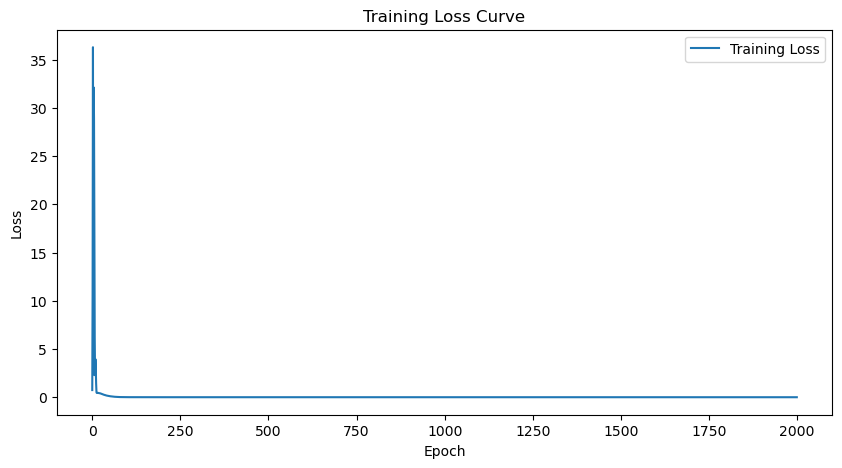

Final Model Accuracy: 84.62%
Final Model F1-score: 0.8182


In [22]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [23]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [24]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.76      1.00      0.87        13
non_infringement       1.00      0.69      0.82        13

        accuracy                           0.85        26
       macro avg       0.88      0.85      0.84        26
    weighted avg       0.88      0.85      0.84        26



/tmp/ipykernel_3121253/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
